In [1]:
!wget https://goo.gl/8hY5ER -O urbansound8k_metadata.zip
!file urbansound8k_metadata.zip
import tarfile

file_path = "/content/urbansound8k_metadata.zip"  # actually a .tar.gz
extract_path = "/content/UrbanSound8K"

with tarfile.open(file_path, "r:gz") as tar:
    tar.extractall(path=extract_path)

print("Extraction complete.")

--2025-05-21 00:20:47--  https://goo.gl/8hY5ER
Resolving goo.gl (goo.gl)... 142.250.153.101, 142.250.153.138, 142.250.153.100, ...
Connecting to goo.gl (goo.gl)|142.250.153.101|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://zenodo.org/record/1203745/files/UrbanSound8K.tar.gz [following]
--2025-05-21 00:20:47--  https://zenodo.org/record/1203745/files/UrbanSound8K.tar.gz
Resolving zenodo.org (zenodo.org)... 188.185.48.194, 188.185.43.25, 188.185.45.92, ...
Connecting to zenodo.org (zenodo.org)|188.185.48.194|:443... connected.
HTTP request sent, awaiting response... 301 MOVED PERMANENTLY
Location: /records/1203745/files/UrbanSound8K.tar.gz [following]
--2025-05-21 00:20:48--  https://zenodo.org/records/1203745/files/UrbanSound8K.tar.gz
Reusing existing connection to zenodo.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 6023741708 (5.6G) [application/octet-stream]
Saving to: ‘urbansound8k_metadata.zip’

urbansound8k_metada 100%[===

In [2]:
import os
import numpy as np
import pandas as pd
import librosa
import librosa.display
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models, optimizers, callbacks, regularizers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization, Dropout

In [3]:
# Set random seed for reproducibility
np.random.seed(42)

# Paths
DATASET_PATH = "/content/UrbanSound8K/UrbanSound8K"
AUDIO_PATH = os.path.join(DATASET_PATH, "audio")
METADATA_PATH = os.path.join(DATASET_PATH, "metadata", "UrbanSound8K.csv")

# Enhanced Parameters
SAMPLE_RATE = 22050
DURATION = 4  # seconds
SAMPLES_PER_TRACK = SAMPLE_RATE * DURATION
NUM_MFCC = 64  # Increased from 40 to capture more features
N_FFT = 2048
HOP_LENGTH = 512
N_MELS = 128  # For mel-spectrogram

In [4]:
# Load metadata
metadata = pd.read_csv(METADATA_PATH)

In [5]:
# Function to augment audio data
def augment_audio(signal):
    # Time stretching
    rate = np.random.uniform(0.9, 1.1)
    signal = librosa.effects.time_stretch(signal, rate=rate)

    # Pitch shifting
    n_steps = np.random.randint(-1, 1)
    signal = librosa.effects.pitch_shift(signal, sr=SAMPLE_RATE, n_steps=n_steps)

    # Add small amount of noise
    noise = np.random.randn(len(signal))
    signal = signal + 0.002 * noise

    # Random gain
    gain = np.random.uniform(0.9, 1.1)
    signal = signal * gain

    return signal

In [6]:
# Function to extract features
def extract_features(file_path, augment=False):
    try:
        # Load audio file
        signal, sr = librosa.load(file_path, sr=SAMPLE_RATE, duration=DURATION)

        # Apply augmentation (only for training data)
        if augment:
            signal = augment_audio(signal)

        # Ensure consistent length
        if len(signal) < SAMPLES_PER_TRACK:
            pad_width = SAMPLES_PER_TRACK - len(signal)
            signal = np.pad(signal, (0, pad_width), mode='constant')
        else:
            signal = signal[:SAMPLES_PER_TRACK]

        # Extract MFCCs with delta and delta-delta features
        mfcc = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=NUM_MFCC,
                                   n_fft=N_FFT, hop_length=HOP_LENGTH)
        mfcc_delta = librosa.feature.delta(mfcc)
        mfcc_delta2 = librosa.feature.delta(mfcc, order=2)

        # Extract Mel-spectrogram
        mel = librosa.feature.melspectrogram(y=signal, sr=sr, n_mels=N_MELS,
                                           n_fft=N_FFT, hop_length=HOP_LENGTH)
        mel_db = librosa.power_to_db(mel, ref=np.max)

        # Stack all features
        features = np.vstack([mfcc, mfcc_delta, mfcc_delta2, mel_db])
        return features.T  # Transpose to (time, features)

    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

In [7]:
# Initialize lists
features = []
labels = []

# Iterate through the dataset with progress bar
print("Extracting features from audio files...")
for index, row in tqdm(metadata.iterrows(), total=len(metadata)):
    file_path = os.path.join(AUDIO_PATH, f"fold{row['fold']}", row['slice_file_name'])
    feature = extract_features(file_path, augment=False)  # No augmentation for initial extraction
    if feature is not None:
        features.append(feature)
        labels.append(row['class'])

Extracting features from audio files...


100%|██████████| 8732/8732 [05:05<00:00, 28.58it/s]


In [8]:
# Prepare data
X = np.array(features)
y = np.array(labels)

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_categorical = to_categorical(y_encoded)

In [9]:
# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_encoded), y=y_encoded)
class_weights = dict(enumerate(class_weights))

# Split data - stratified to maintain class distribution
X_train, X_test, y_train, y_test = train_test_split(
    X, y_categorical, test_size=0.2, random_state=42, stratify=y_encoded)

In [10]:
# Expand dimensions for CNN input
X_train = X_train[..., np.newaxis]
X_test = X_test[..., np.newaxis]


In [11]:
def create_model(input_shape, num_classes):
    input_layer = layers.Input(shape=input_shape)

    # First Conv Block
    x = layers.Conv2D(64, (3, 3), activation='relu',
                     kernel_regularizer=regularizers.l2(0.001))(input_layer)
    x = BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = Dropout(0.3)(x)

    # Second Conv Block
    x = layers.Conv2D(128, (3, 3), activation='relu',
                     kernel_regularizer=regularizers.l2(0.001))(x)
    x = BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = Dropout(0.3)(x)

    # Third Conv Block
    x = layers.Conv2D(256, (3, 3), activation='relu',
                     kernel_regularizer=regularizers.l2(0.001))(x)
    x = BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = Dropout(0.3)(x)

    # Fourth Conv Block
    x = layers.Conv2D(512, (3, 3), activation='relu',
                     kernel_regularizer=regularizers.l2(0.001))(x)
    x = BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = Dropout(0.3)(x)

    # Flatten and Dense
    x = layers.Flatten()(x)
    x = layers.Dense(512, activation='relu',
                    kernel_regularizer=regularizers.l2(0.001))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    output_layer = layers.Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=input_layer, outputs=output_layer)
    return model

In [12]:
# Create model
input_shape = X_train.shape[1:]  # (time, features, 1)
num_classes = y_categorical.shape[1]
model = create_model(input_shape, num_classes)

# Optimizer with learning rate scheduling
optimizer = optimizers.Adam(learning_rate=0.001)

# Compile model
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Model summary
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 173, 320, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 171, 318, 64)   │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 171, 318, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 85, 159, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 85, 159, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 83, 157, 128)   │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 83, 157, 128)   │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 41, 78, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 41, 78, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 39, 76, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 39, 76, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 19, 38, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 19, 38, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 17, 36, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 17, 36, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 8, 18, 512)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 8, 18, 512)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 73728)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    37,749,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴─────────────

 Total params: 39,310,090 (149.96 MB)

 Trainable params: 39,307,146 (149.94 MB)

 Non-trainable params: 2,944 (11.50 KB)

In [13]:

# Callbacks
early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=15,
                                    restore_best_weights=True, verbose=1)
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                                       patience=5, min_lr=1e-6, verbose=1)
model_checkpoint = callbacks.ModelCheckpoint('best_model.h5',
                                           monitor='val_accuracy',
                                           save_best_only=True,
                                           mode='max',
                                           verbose=1)

# Train the model
print("Training the model...")
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,  # Large number because we're using early stopping
    batch_size=64,
    callbacks=[early_stop, reduce_lr, model_checkpoint],
    class_weight=class_weights,
    verbose=1
)

Training the model...
Epoch 1/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step - accuracy: 0.4380 - loss: 4.1755
Epoch 1: val_accuracy improved from -inf to 0.20950, saving model to best_model.h5


110/110 ━━━━━━━━━━━━━━━━━━━━ 98s 602ms/step - accuracy: 0.4390 - loss: 4.1726 - val_accuracy: 0.2095 - val_loss: 7.1389 - learning_rate: 0.0010
Epoch 2/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step - accuracy: 0.7083 - loss: 3.1340
Epoch 2: val_accuracy did not improve from 0.20950
110/110 ━━━━━━━━━━━━━━━━━━━━ 36s 324ms/step - accuracy: 0.7086 - loss: 3.1319 - val_accuracy: 0.1729 - val_loss: 7.8450 - learning_rate: 0.0010
Epoch 3/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step - accuracy: 0.7960 - loss: 2.3822
Epoch 3: val_accuracy did not improve from 0.20950
110/110 ━━━━━━━━━━━━━━━━━━━━ 41s 321ms/step - accuracy: 0.7959 - loss: 2.3817 - val_accuracy: 0.1700 - val_loss: 8.2121 - learning_rate: 0.0010
Epoch 4/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step - accuracy: 0.8268 - loss: 2.0906
Epoch 4: val_accuracy improved from 0.20950 to 0.62851, saving model to best_model.h5


110/110 ━━━━━━━━━━━━━━━━━━━━ 42s 385ms/step - accuracy: 0.8268 - loss: 2.0901 - val_accuracy: 0.6285 - val_loss: 2.6152 - learning_rate: 0.0010
Epoch 5/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step - accuracy: 0.8617 - loss: 1.8691
Epoch 5: val_accuracy improved from 0.62851 to 0.78134, saving model to best_model.h5


110/110 ━━━━━━━━━━━━━━━━━━━━ 95s 505ms/step - accuracy: 0.8617 - loss: 1.8688 - val_accuracy: 0.7813 - val_loss: 2.0153 - learning_rate: 0.0010
Epoch 6/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step - accuracy: 0.8726 - loss: 1.7598
Epoch 6: val_accuracy did not improve from 0.78134
110/110 ━━━━━━━━━━━━━━━━━━━━ 62s 322ms/step - accuracy: 0.8725 - loss: 1.7607 - val_accuracy: 0.6691 - val_loss: 2.8789 - learning_rate: 0.0010
Epoch 7/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step - accuracy: 0.8806 - loss: 1.8334
Epoch 7: val_accuracy did not improve from 0.78134
110/110 ━━━━━━━━━━━━━━━━━━━━ 41s 321ms/step - accuracy: 0.8806 - loss: 1.8327 - val_accuracy: 0.6737 - val_loss: 2.3188 - learning_rate: 0.0010
Epoch 8/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step - accuracy: 0.8907 - loss: 1.6546
Epoch 8: val_accuracy did not improve from 0.78134
110/110 ━━━━━━━━━━━━━━━━━━━━ 41s 323ms/step - accuracy: 0.8906 - loss: 1.6547 - val_accuracy: 0.6388 - val_loss: 2.6197 - learning_rate: 0.0010
Epoch 9

110/110 ━━━━━━━━━━━━━━━━━━━━ 87s 740ms/step - accuracy: 0.9704 - loss: 1.2940 - val_accuracy: 0.9107 - val_loss: 1.3662 - learning_rate: 2.0000e-04
Epoch 13/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step - accuracy: 0.9733 - loss: 1.1389
Epoch 13: val_accuracy improved from 0.91070 to 0.92387, saving model to best_model.h5


110/110 ━━━━━━━━━━━━━━━━━━━━ 101s 915ms/step - accuracy: 0.9733 - loss: 1.1386 - val_accuracy: 0.9239 - val_loss: 1.2057 - learning_rate: 2.0000e-04
Epoch 14/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step - accuracy: 0.9825 - loss: 1.0036
Epoch 14: val_accuracy did not improve from 0.92387
110/110 ━━━━━━━━━━━━━━━━━━━━ 78s 327ms/step - accuracy: 0.9825 - loss: 1.0033 - val_accuracy: 0.9222 - val_loss: 1.1218 - learning_rate: 2.0000e-04
Epoch 15/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step - accuracy: 0.9797 - loss: 0.9095
Epoch 15: val_accuracy did not improve from 0.92387
110/110 ━━━━━━━━━━━━━━━━━━━━ 36s 325ms/step - accuracy: 0.9797 - loss: 0.9093 - val_accuracy: 0.9199 - val_loss: 1.0557 - learning_rate: 2.0000e-04
Epoch 16/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step - accuracy: 0.9858 - loss: 0.8180
Epoch 16: val_accuracy improved from 0.92387 to 0.92559, saving model to best_model.h5


110/110 ━━━━━━━━━━━━━━━━━━━━ 95s 871ms/step - accuracy: 0.9858 - loss: 0.8178 - val_accuracy: 0.9256 - val_loss: 0.9605 - learning_rate: 2.0000e-04
Epoch 17/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step - accuracy: 0.9908 - loss: 0.7439
Epoch 17: val_accuracy did not improve from 0.92559
110/110 ━━━━━━━━━━━━━━━━━━━━ 82s 323ms/step - accuracy: 0.9908 - loss: 0.7438 - val_accuracy: 0.9090 - val_loss: 0.9778 - learning_rate: 2.0000e-04
Epoch 18/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step - accuracy: 0.9871 - loss: 0.6882
Epoch 18: val_accuracy improved from 0.92559 to 0.93761, saving model to best_model.h5


110/110 ━━━━━━━━━━━━━━━━━━━━ 93s 805ms/step - accuracy: 0.9871 - loss: 0.6881 - val_accuracy: 0.9376 - val_loss: 0.8121 - learning_rate: 2.0000e-04
Epoch 19/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step - accuracy: 0.9895 - loss: 0.6377
Epoch 19: val_accuracy did not improve from 0.93761
110/110 ━━━━━━━━━━━━━━━━━━━━ 90s 327ms/step - accuracy: 0.9895 - loss: 0.6377 - val_accuracy: 0.9307 - val_loss: 0.7787 - learning_rate: 2.0000e-04
Epoch 20/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step - accuracy: 0.9860 - loss: 0.6128
Epoch 20: val_accuracy did not improve from 0.93761
110/110 ━━━━━━━━━━━━━━━━━━━━ 40s 319ms/step - accuracy: 0.9860 - loss: 0.6128 - val_accuracy: 0.9290 - val_loss: 0.7901 - learning_rate: 2.0000e-04
Epoch 21/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step - accuracy: 0.9800 - loss: 0.6393
Epoch 21: val_accuracy did not improve from 0.93761
110/110 ━━━━━━━━━━━━━━━━━━━━ 41s 322ms/step - accuracy: 0.9799 - loss: 0.6393 - val_accuracy: 0.8935 - val_loss: 0.9457 - learning_ra

110/110 ━━━━━━━━━━━━━━━━━━━━ 96s 827ms/step - accuracy: 0.9952 - loss: 0.4466 - val_accuracy: 0.9473 - val_loss: 0.5930 - learning_rate: 4.0000e-05
Epoch 34/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step - accuracy: 0.9962 - loss: 0.4301
Epoch 34: val_accuracy improved from 0.94734 to 0.94791, saving model to best_model.h5


110/110 ━━━━━━━━━━━━━━━━━━━━ 98s 893ms/step - accuracy: 0.9962 - loss: 0.4300 - val_accuracy: 0.9479 - val_loss: 0.5814 - learning_rate: 4.0000e-05
Epoch 35/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step - accuracy: 0.9967 - loss: 0.4143
Epoch 35: val_accuracy improved from 0.94791 to 0.95077, saving model to best_model.h5


110/110 ━━━━━━━━━━━━━━━━━━━━ 133s 815ms/step - accuracy: 0.9967 - loss: 0.4143 - val_accuracy: 0.9508 - val_loss: 0.5513 - learning_rate: 4.0000e-05
Epoch 36/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step - accuracy: 0.9970 - loss: 0.4026
Epoch 36: val_accuracy improved from 0.95077 to 0.95478, saving model to best_model.h5


110/110 ━━━━━━━━━━━━━━━━━━━━ 154s 924ms/step - accuracy: 0.9970 - loss: 0.4026 - val_accuracy: 0.9548 - val_loss: 0.5395 - learning_rate: 4.0000e-05
Epoch 37/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step - accuracy: 0.9971 - loss: 0.3899
Epoch 37: val_accuracy did not improve from 0.95478
110/110 ━━━━━━━━━━━━━━━━━━━━ 77s 325ms/step - accuracy: 0.9971 - loss: 0.3899 - val_accuracy: 0.9548 - val_loss: 0.5284 - learning_rate: 4.0000e-05
Epoch 38/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step - accuracy: 0.9978 - loss: 0.3759
Epoch 38: val_accuracy did not improve from 0.95478
110/110 ━━━━━━━━━━━━━━━━━━━━ 40s 320ms/step - accuracy: 0.9978 - loss: 0.3759 - val_accuracy: 0.9428 - val_loss: 0.5624 - learning_rate: 4.0000e-05
Epoch 39/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step - accuracy: 0.9983 - loss: 0.3648
Epoch 39: val_accuracy improved from 0.95478 to 0.95707, saving model to best_model.h5


110/110 ━━━━━━━━━━━━━━━━━━━━ 96s 878ms/step - accuracy: 0.9982 - loss: 0.3648 - val_accuracy: 0.9571 - val_loss: 0.5097 - learning_rate: 4.0000e-05
Epoch 40/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step - accuracy: 0.9966 - loss: 0.3551
Epoch 40: val_accuracy did not improve from 0.95707
110/110 ━━━━━━━━━━━━━━━━━━━━ 82s 328ms/step - accuracy: 0.9966 - loss: 0.3551 - val_accuracy: 0.9525 - val_loss: 0.4996 - learning_rate: 4.0000e-05
Epoch 41/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step - accuracy: 0.9978 - loss: 0.3442
Epoch 41: val_accuracy did not improve from 0.95707
110/110 ━━━━━━━━━━━━━━━━━━━━ 35s 321ms/step - accuracy: 0.9978 - loss: 0.3441 - val_accuracy: 0.9525 - val_loss: 0.5034 - learning_rate: 4.0000e-05
Epoch 42/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step - accuracy: 0.9978 - loss: 0.3371
Epoch 42: val_accuracy did not improve from 0.95707
110/110 ━━━━━━━━━━━━━━━━━━━━ 41s 321ms/step - accuracy: 0.9978 - loss: 0.3371 - val_accuracy: 0.9531 - val_loss: 0.5148 - learning_ra

In [14]:
# Load the best model
model = models.load_model('best_model.h5')


Evaluating the model...
55/55 - 10s - 174ms/step - accuracy: 0.9571 - loss: 0.5097

Test Accuracy: 95.71%


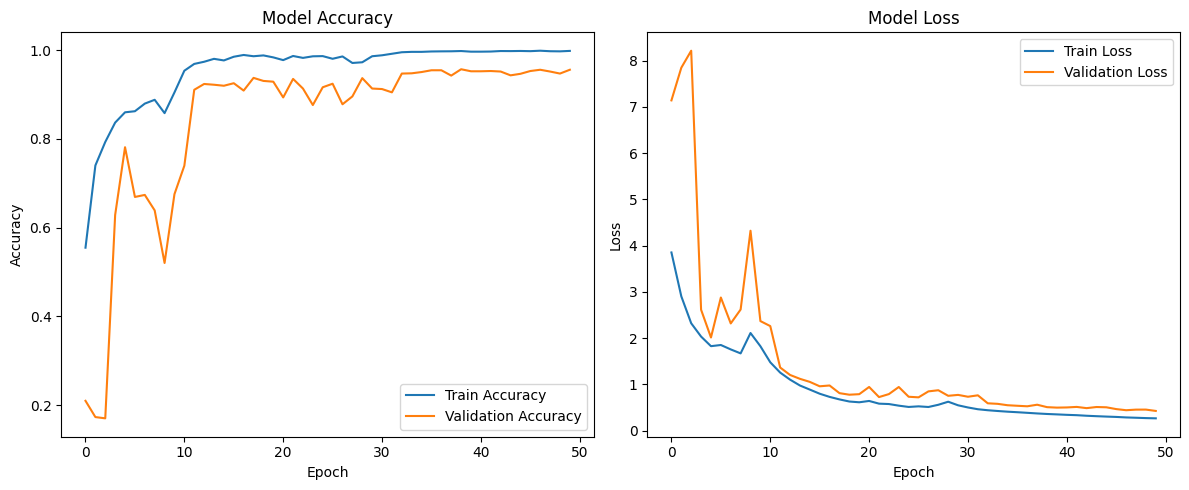

In [15]:
# Evaluation
print("\nEvaluating the model...")
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=2)
print(f"\nTest Accuracy: {test_accuracy * 100:.2f}%")

# Plot training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

55/55 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step


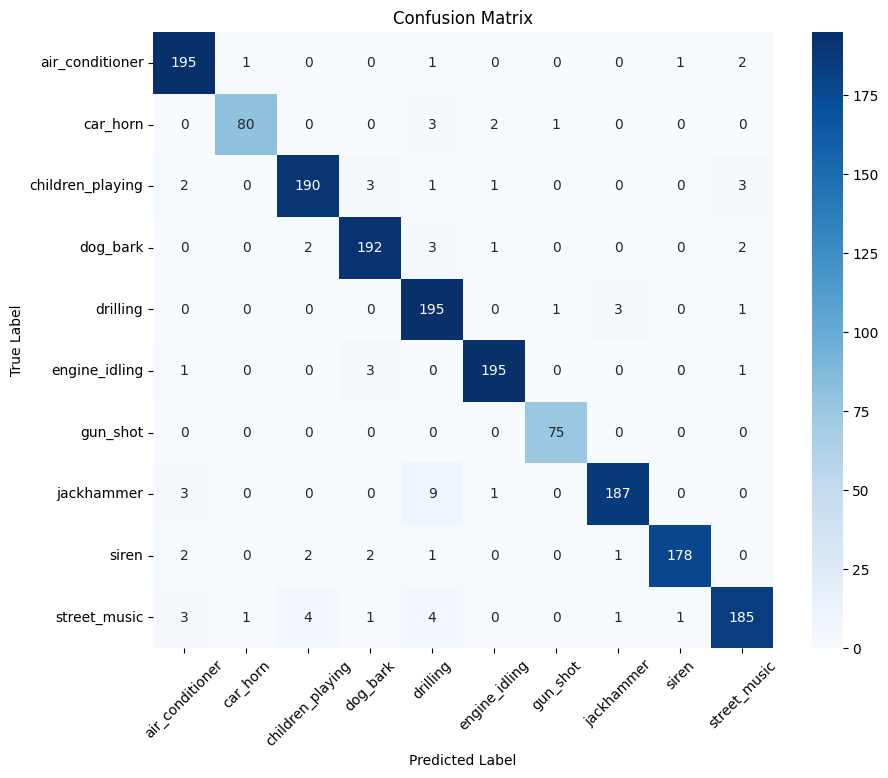

In [16]:
# Confusion matrix
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

In [17]:
# Classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes,
                          target_names=label_encoder.classes_))


Classification Report:
                  precision    recall  f1-score   support

 air_conditioner       0.95      0.97      0.96       200
        car_horn       0.98      0.93      0.95        86
children_playing       0.96      0.95      0.95       200
        dog_bark       0.96      0.96      0.96       200
        drilling       0.90      0.97      0.94       200
   engine_idling       0.97      0.97      0.97       200
        gun_shot       0.97      1.00      0.99        75
      jackhammer       0.97      0.94      0.95       200
           siren       0.99      0.96      0.97       186
    street_music       0.95      0.93      0.94       200

        accuracy                           0.96      1747
       macro avg       0.96      0.96      0.96      1747
    weighted avg       0.96      0.96      0.96      1747



In [21]:
def predict_audio_class(file_path):
    # Extract features
    features = extract_features(file_path, augment=False)
    if features is None:
        return "Error processing file" # This is the problematic return

    # Prepare input
    features = np.array([features])
    features = features[..., np.newaxis]

    # Predict
    prediction = model.predict(features)
    predicted_class = np.argmax(prediction)
    confidence = np.max(prediction)

    return label_encoder.classes_[predicted_class], confidence

In [23]:
# Example usage
test_file = "/content/174840__jakobthiesen__mitsubishi-imiev-electric-car-horn-long.wav"
result = predict_audio_class(test_file) # Capture the result in a single variable

if isinstance(result, tuple) and len(result) == 2:
    class_name, confidence = result
    print(f"Predicted class: {class_name} with confidence {confidence:.2f}")
else:
    # Handle the error case, 'result' will be the error string
    print(f"Prediction failed: {result}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Predicted class: car_horn with confidence 1.00


In [25]:
# Example usage
test_file = "/content/236271__delphidebrain__jazz-the-dog-howl-bark-198.wav"
result = predict_audio_class(test_file) # Capture the result in a single variable

if isinstance(result, tuple) and len(result) == 2:
    class_name, confidence = result
    print(f"Predicted class: {class_name} with confidence {confidence:.2f}")
else:
    # Handle the error case, 'result' will be the error string
    print(f"Prediction failed: {result}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
Predicted class: dog_bark with confidence 1.00
